## Building a computer vision model


### **Computer vision libraries**


| PyTorch module | What does it do? |
| ----- | ----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Base domain libraty for PyTorch computer vision |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Get datasets and data loading functions for computer vision here. It also contains [a series of base classes for making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). |
| [`torchvision.models`](https://pytorch.org/vision/stable/models.html) | Get pre trained computer vision models that you can leverage for your own problems | 
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | Functions for manipulating your vision data (images) to be suitable for use with an ML model | 
| [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) | Base dataset class for PyTorch.  | 
| [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Creates a Python iterable over a dataset (created with `torch.utils.data.Dataset`). 


In [62]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
print(torch.__version__)
print(torchvision.__version__)

2.7.1+cpu
0.22.1+cpu


### **1. Getting a dataset**

We are using FashionMNIST dataset for this notebook, the dataset contains images of different items of clothing and we will be trying to build a model that can recognise different items

In [63]:
# Download FashionMNIST dataset

data=torchvision.datasets.FashionMNIST("data",train=True,
                                       download=True,transform=ToTensor(),target_transform=None)

In [64]:
test_data=torchvision.datasets.FashionMNIST("test_data",train=False,
                                       download=True,transform=ToTensor(),target_transform=None)

In [65]:
# Inspect data
len(data),len(test_data)

(60000, 10000)

In [66]:
# See the first training example
image,label=data[0]
print(image,label)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [67]:
# Inspect the class labels
class_names=data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [68]:
class_to_idx=data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [69]:
# Check shape of image
print(f"Image shape : {image.shape} Label shape : {label}")

Image shape : torch.Size([1, 28, 28]) Label shape : 9


The colour channel is one because images are grayscale 

9


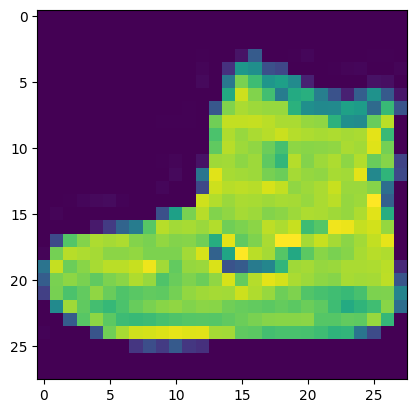

In [70]:
# Visualize image 
image,label=data[0]
"""
plt.imshow(image)- this results in an error because the input shape of [1,28,28] doesnt match
with the expected input shape of matplotlib

our image is greyscale so we can get rid of 1 in [1,28,28] using squeeze operation
"""

plt.imshow(image.squeeze())
print(label)

(-0.5, 27.5, 27.5, -0.5)

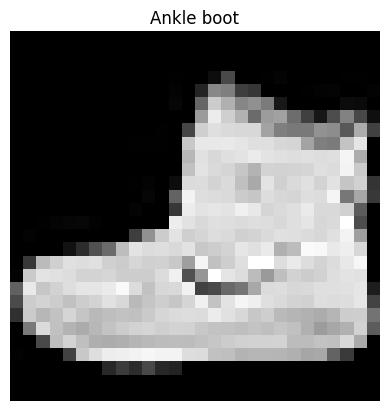

In [71]:
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)


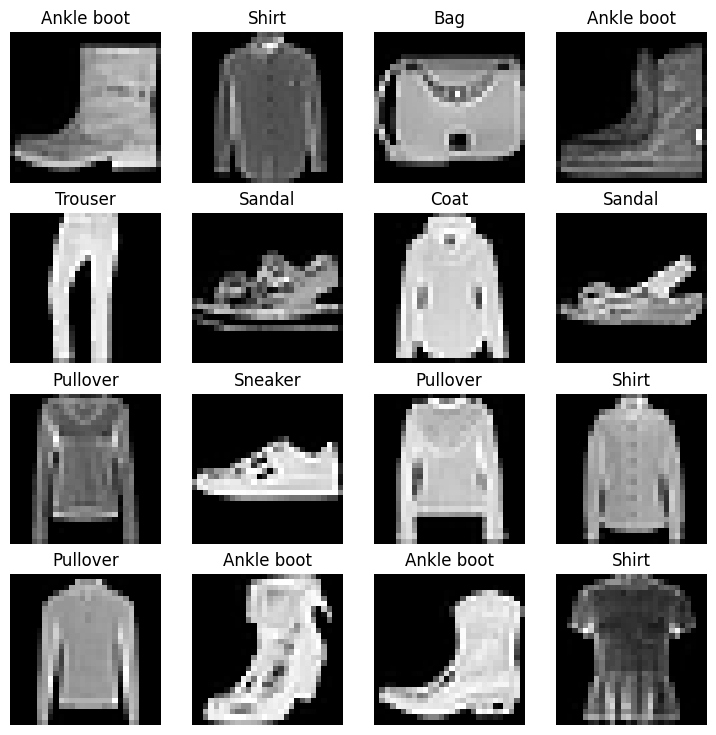

In [72]:
# Plot more images
torch.manual_seed(42)
fig=plt.figure(figsize=(9,9))
rows,cols=4,4
for i in range(1,rows*cols+1):
    random_idx=torch.randint(0,len(data),size=[1]).item()
    img,label=data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

### **2. Prepare DataLoader**

Right now our data is in form of PyTorch dataset

DataLoader helps transform our dataset into a python iterable

More specifically we want to turn our data into batches (or mini-batches). We do this becuase:

1. It is more computationally efficient, as in your computing hardware may not be able to look (store into memory) at 60000 images in one hit . So we break it down to 32 images at a time (batch size=32)
2. It gives our neural network more chances to update its gradients per epoch


In [73]:
data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: test_data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [74]:
from torch.utils.data import DataLoader

train_dataloader=DataLoader(dataset=data,batch_size=32,shuffle=True)

test_dataloader=DataLoader(dataset=test_data,batch_size=32,shuffle=False)

train_dataloader,test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x19dec02f790>,
 <torch.utils.data.dataloader.DataLoader at 0x19dec02f640>)

In [75]:
# Check what we have created
print(f"DataLoaders: {train_dataloader,test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")


DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000019DEC02F790>, <torch.utils.data.dataloader.DataLoader object at 0x0000019DEC02F640>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [76]:
#  Lets check what is inside our dataloader
train_features_batch,train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label :8, label size: torch.Size([])


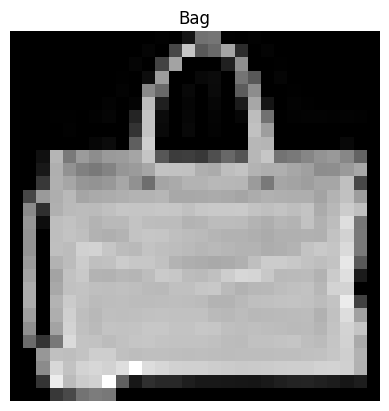

In [77]:
# Visualize a image in a batch
random_idx=torch.randint(0,len(train_features_batch),size=[1]).item()
img,label=train_features_batch[random_idx],train_labels_batch[random_idx]

plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label :{label}, label size: {label.shape}")


### **3. Model 0: Build a Baseline model**

A baseline model is a simple mdoel you will try and improve upon with subsequent experiments/models


In [78]:
# Create a flatten layer
flatten_model=nn.Flatten()

# Get a single sample 
X=train_features_batch[0]
X.shape

# Flatten the sample
output=flatten_model(X)

# Print output
print(f"Shape before flattening:{X.shape} -> [color_channels,height,width]")
print(f"Shape after flattening:{output.shape} -> [color_channels,height*width]")


Shape before flattening:torch.Size([1, 28, 28]) -> [color_channels,height,width]
Shape after flattening:torch.Size([1, 784]) -> [color_channels,height*width]


The reason we are doing this is becuase as baseline we will build a linear layer and a linear layer cannot handle multi dimensional data like this


In [79]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self,input_shape:int,
                 hidden_units:int,
                 output_shape:int):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_shape)
        )
    def forward(self,x):
        return self.layer_stack(x)

In [80]:
torch.manual_seed(42)

# Set up model with input parameters

model_0=FashionMNISTModelV0(input_shape=784, # 28*28
                            hidden_units=10,
                            output_shape=len(class_names))

model_0


FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [81]:
dummy_x=torch.rand([1,1,28,28])
model_0(dummy_x)


tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### **3.1 Set up loss,optimizer, evaluation metrics**

* Loss function- since we are working with multi class data , our loss fucntion will be `nn.CrossEntropyLoss()`
* Optimizer- our optimizer, `torch.optim.SGD()`
* Evaluation metrics- since we're working on a classification problem , we will use accuracy as evaluation metric


In [82]:
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()  # this will return a single value with sum of labels where pred=true
    acc=(correct/len(y_pred))*100
    return acc

In [83]:
# Setup loss and optimiser
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1
)

### **3.2 Creating a function to time our experiments**

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [84]:
from timeit import default_timer as timer

def print_train_time(start:float,
                    end:float,
                    device:torch.device=None):

    total_time=end-start
    print(f"Train time on device {device} : {total_time:.3f} seconds")
    return total_time


In [85]:
start_time=timer()

end_time=timer()
print_train_time(start_time,end_time,device="cpu")

Train time on device cpu : 0.000 seconds


1.2000033166259527e-05

### **3.3 Creating a training loop and training a model on batches of data**

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss per batch
3. Loop through testing batches, perform testing steps, calculate the test loss per batch
4. Print whats happening and time it all

In [86]:

import tqdm
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train() 
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y) 
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on device cpu : 14.045 seconds


### **4. Make predictions and get Model0 results**


In [87]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
    """
    Returns a dictionary containing the results of model predicting on data_loader
    """
    loss,acc=0.0,0.0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            y_pred=model(X)
            loss+=loss_fn(y_pred,y)
            acc+=accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
        loss/=len(data_loader)
        acc/=len(data_loader)
    return{"model_name": model.__class__.__name__, #only works if model was created with a class
           "model_loss": loss.item(),
           "model_acc": acc} 
# Calculate model 0 results on text dataset
model_0_results=eval_model(model=model_0,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn)
model_0_results



{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

### **6. Building a model with non linearity**

We learned about the power of non linearity in the second chapter.

In [88]:
# Create a model with non linear and linear layers

class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape:int,
                 hidden_units:int,output_shape:int):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
            nn.ReLU()
        )
    def forward(self,x:torch.Tensor):
        return self.layer_stack(x)


In [89]:
torch.manual_seed(42)
model_1=FashionMNISTModelV1(input_shape=784,
                            hidden_units=10,
                            output_shape=len(class_names))

In [90]:
# Setup loss and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)


### **6.2 Functionizing training and test loops**

Lets now setup a function for training and testing loop

In [91]:
device="cpu"

In [92]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() 
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) 
            )
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

Now lets test model 1

In [93]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time on device cpu : 13.066 seconds


In [94]:
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

Lets compare with baseline results

In [95]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

Notice that the performance has got worse by introducing non linearity in this case

This could be because the model is overfitting on the training data- 

Overfitting means our model is learning the training data well but those patterns aren't generalizing to the testing data.

Two of the main ways to fix overfitting include:
1. Using a smaller or different model (some models fit certain kinds of data better than others).
2. Using a larger dataset (the more data, the more chance a model has to learn generalizable patterns).

### Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets. 

CNN's are known for their ability to find patterns in visual data.


A CNN typically follow the structure:

Input layer -> [Convolutional layer -> Activation layer -> Pooling layer] -> Output layer

Where the contents of [Convolutional layer -> Activation layer -> Pooling layer] can be upscaled and repeated multiple times , depending on requirements

Inorder to visualize how CNN's work check [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)

In [96]:
# Create a CNN
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG model from CNN explainer website
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(x.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [97]:
torch.manual_seed(42)
model_2=FashionMNISTModelV2(input_shape=1,
                            hidden_units=10,
                            output_shape=len(class_names))


In [98]:
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### **7.1 Stepping through nn.Conv2d**

* [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), also known as a convolutional layer.
* [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), also known as a max pooling layer.

> **Question:** What does the "2d" in `nn.Conv2d()` stand for?
>
> The 2d is for 2-dimensional data. As in, our images have two dimensions: height and width. Yes, there's color channel dimension but each of the color channel dimensions have two dimensions too: height and width.
>
> For other dimensional data (such as 1D for text or 3D for 3D objects) there's also `nn.Conv1d()` and `nn.Conv3d()`. 

In [99]:
# Create some dummy data

torch.manual_seed(42)

# Create a batch of images

images=torch.randn(size=(32,3,64,64))
test_image=images[0]
print(f"Image batch shape : {images.shape}")
print(f"Single image shape : {test_image.shape}")
print(f"Test image : {test_image}")

Image batch shape : torch.Size([32, 3, 64, 64])
Single image shape : torch.Size([3, 64, 64])
Test image : tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[

In [100]:
torch.manual_seed(42)
# Create a single conv2d layer
conv_layer=nn.Conv2d(in_channels=3,out_channels=10,
                    kernel_size=3,stride=1,padding=0)

# Pass data through convolutional layer
conv_output=conv_layer(test_image)
conv_output

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [101]:
conv_output.shape

torch.Size([10, 62, 62])

### **7.2 Stepping through nn.MaxPoool2d**

In [102]:
print(f"Test image original shape : {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")


Test image original shape : torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])


In [103]:
# Create a conv layer
max_pool_layer=nn.MaxPool2d(kernel_size=2)

# Pass data through conv layer
test_image_through_conv=conv_layer(test_image)
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through max pool layer
test_image_through_conv_and_max_pool=max_pool_layer(test_image_through_conv)
print(F"Shape after going through conv_layer() and max_pool_layer() : {test_image_through_conv_and_max_pool.shape}")

Shape after going through conv_layer(): torch.Size([10, 62, 62])
Shape after going through conv_layer() and max_pool_layer() : torch.Size([10, 31, 31])


In [104]:
torch.manual_seed(42)

# Create a random tensor with similar number of dimensions to our images
random_tensor=torch.rand(size=(1,2,2))
print(f"Random tensor : {random_tensor}")
print(F"Shape of random tensor :{random_tensor.shape}")

max_pool_layer=nn.MaxPool2d(kernel_size=2)
max_pool_tensor=max_pool_layer(random_tensor)
print(f"Max pool tensor: {max_pool_tensor}")
print(F"Max pool tensor shape : {max_pool_tensor.shape}")

Random tensor : tensor([[[0.8823, 0.9150],
         [0.3829, 0.9593]]])
Shape of random tensor :torch.Size([1, 2, 2])
Max pool tensor: tensor([[[0.9593]]])
Max pool tensor shape : torch.Size([1, 1, 1])


### **7.2 Setup loss and optimizer**

In [105]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.1)


### **7.2 Training and testing model_2 using training and test functions**


In [106]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58781 | Train accuracy: 78.69%
Test loss: 0.40891 | Test accuracy: 85.16%

Epoch: 1
---------
Train loss: 0.36143 | Train accuracy: 86.86%
Test loss: 0.35511 | Test accuracy: 86.82%

Epoch: 2
---------
Train loss: 0.32243 | Train accuracy: 88.31%
Test loss: 0.31614 | Test accuracy: 88.56%

Train time on device cpu : 61.908 seconds


In [107]:
model_2_results=eval_model(model=model_2,data_loader=test_dataloader,
                            loss_fn=loss_fn,accuracy_fn=accuracy_fn)
model_2_results


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3161371350288391,
 'model_acc': 88.55830670926518}

### **8. Comparing rmodel results and training time**

In [108]:
import pandas as pd
compare_results=pd.DataFrame([model_0_results,model_1_results,model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.316137,88.558307


Text(0, 0.5, 'model')

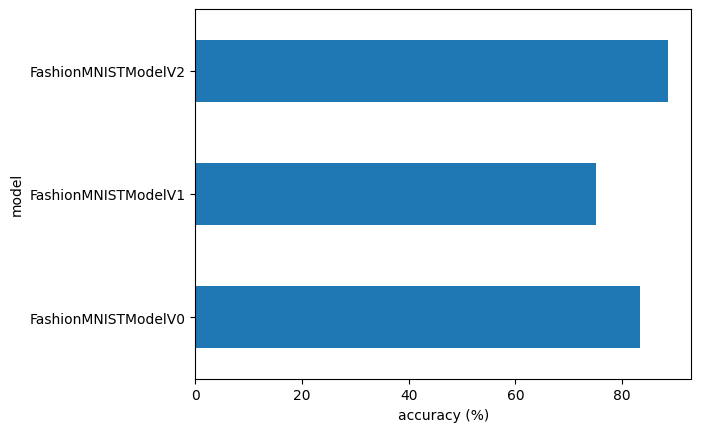

In [109]:
# Visualize our model results

compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

###  **9. Make and evaluate random predictions with best model**


In [110]:
def make_predictions(model:torch.nn.Module,
                        data:list,
                        device:torch.device = device):
    pred_probs=[]
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample=torch.unsqueeze(sample,dim=0).to(device)
            pred_logits=model(sample)
            pred_prob=torch.softmax(pred_logits.squeeze(),dim=0)
            pred_probs.append(pred_prob)
    return torch.stack(pred_probs)

In [111]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


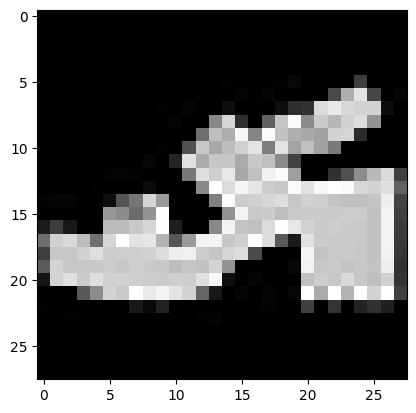

In [112]:
plt.imshow(test_samples[0].squeeze(),cmap="gray")

In [113]:
# Make predictions on test samples with model 2
pred_probs=make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]


tensor([[3.5622e-07, 2.9647e-07, 3.6690e-07, 8.6100e-07, 7.8417e-08, 9.9970e-01,
         2.2334e-06, 1.2042e-04, 8.8155e-05, 8.4982e-05],
        [3.9813e-02, 6.6415e-01, 1.4076e-03, 1.9907e-01, 4.1271e-02, 1.0095e-04,
         5.2958e-02, 2.4544e-04, 5.5365e-04, 4.3443e-04]])

In [114]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [115]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

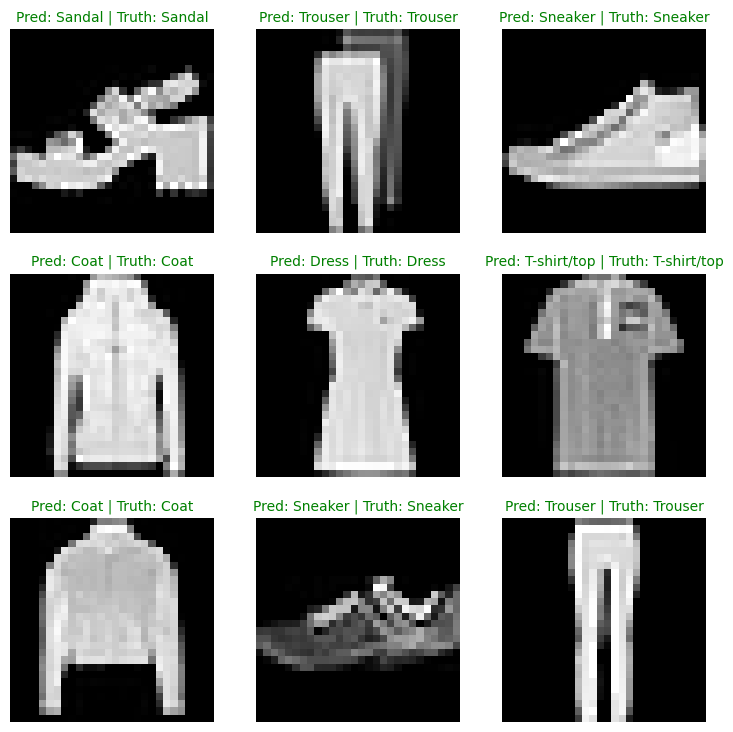

In [116]:
# Plot predictions

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

### **10. Make a confusion matrix for further prediciton evaluation**

To make a confusion matrix, we'll go through three steps:
1. Make predictions with our trained model, `model_2` (a confusion matrix compares predictions to true labels).
2. Make a confusion matrix using [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html?highlight=confusion#confusionmatrix).
3. Plot the confusion matrix using [`mlxtend.plotting.plot_confusion_matrix()`](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

In [117]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

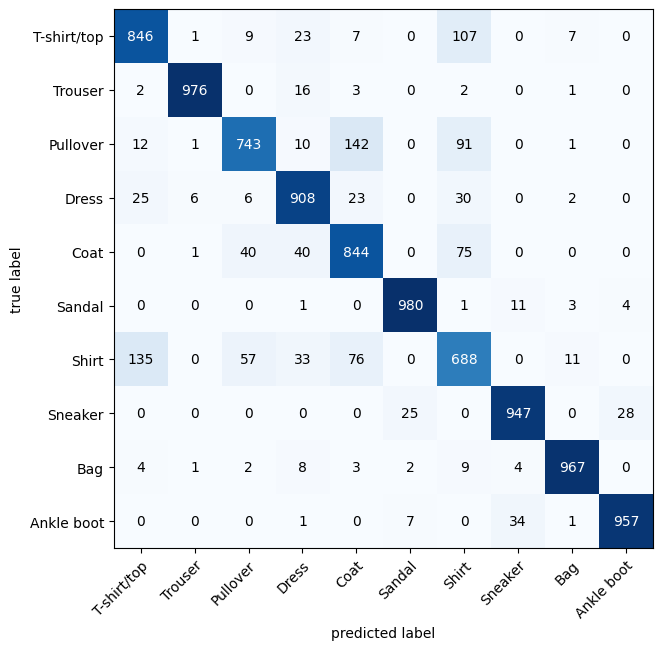

In [120]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get all predictions and targets
y_true = test_data.targets.numpy()
y_pred_all = y_pred_tensor.numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_all)

# Plot it
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(
    conf_mat=cm,
    class_names=class_names,
    figsize=(10, 7)
)